# Testing the FastAPI Application with API Key Authentication

This notebook demonstrates how to test a FastAPI application that implements API key authentication. We'll test both public and protected endpoints to verify that authentication is working correctly.

## 1. Import Required Libraries

First, let's import the necessary libraries for API testing.

In [34]:
import requests
import json
import time
import unittest
from IPython.display import display, HTML

## 2. Define API Endpoints and Parameters

Next, we'll set up variables for our API endpoints and authentication.

In [35]:
# API base URL - update this with your actual deployment URL
# For local testing:
BASE_URL = "http://localhost:8001"

# For Azure Container App (update with your actual URL):
# BASE_URL = "https://web-aca-app.[generated-text].[location-info].azurecontainerapps.io"

# API key - make sure this matches the one used when starting the container
API_KEY = "my-test-api-key"

# Endpoints
PUBLIC_ENDPOINT = f"{BASE_URL}/"
PROTECTED_ENDPOINT = f"{BASE_URL}/hello"

# Headers for authenticated requests
AUTH_HEADERS = {
    "X-API-Key": API_KEY
}

## 3. Basic GET Request - Testing Public Endpoint

Let's start by testing the public endpoint that doesn't require authentication.

In [36]:
# Test the public endpoint (no authentication required)
response = requests.get(PUBLIC_ENDPOINT)

# Check the status code
print(f"Status Code: {response.status_code}")

# Display the response
print("\nResponse Content:")
print(json.dumps(response.json(), indent=2))

Status Code: 200

Response Content:
{
  "message": "This is a public endpoint. To access the protected endpoint, use /hello with an X-API-Key header."
}


## 4. Authentication Implementation

Now, let's test the protected endpoint with and without authentication.

In [37]:
# Test the protected endpoint WITHOUT authentication (should fail)
try:
    response_no_auth = requests.get(PROTECTED_ENDPOINT)
    print(f"Status Code: {response_no_auth.status_code}")
    print(response_no_auth.json())
except Exception as e:
    print(f"Error: {str(e)}")

Status Code: 401
{'detail': 'Invalid API Key'}


In [38]:
# Test the protected endpoint WITH correct authentication
response_with_auth = requests.get(PROTECTED_ENDPOINT, headers=AUTH_HEADERS)

# Check the status code
print(f"Status Code: {response_with_auth.status_code}")

# Display the response
print("\nResponse Content:")
print(json.dumps(response_with_auth.json(), indent=2))

Status Code: 200

Response Content:
{
  "message": "Hello, welcome to FastAPI!"
}


In [39]:
# Test with incorrect API key (should fail)
incorrect_headers = {
    "X-API-Key": "wrong-api-key"
}

response_wrong_key = requests.get(PROTECTED_ENDPOINT, headers=incorrect_headers)
print(f"Status Code: {response_wrong_key.status_code}")
try:
    print(response_wrong_key.json())
except:
    print(response_wrong_key.text)

Status Code: 401
{'detail': 'Invalid API Key'}


## 5. Error Handling

Let's implement proper error handling for different scenarios.

In [40]:
import pandas as pd

def test_endpoint(url, headers=None, expected_status=200, name="Test"):
    """Test an endpoint and return information about the test"""
    start_time = time.time()
    try:
        response = requests.get(url, headers=headers)
        elapsed = time.time() - start_time
        
        result = {
            "name": name,
            "url": url,
            "status_code": response.status_code,
            "elapsed_time": elapsed,
            "success": response.status_code == expected_status,
            "response": response.json() if response.status_code < 400 else response.text
        }
    except Exception as e:
        elapsed = time.time() - start_time
        result = {
            "name": name,
            "url": url,
            "status_code": 0,
            "elapsed_time": elapsed,
            "success": False,
            "response": str(e)
        }
    return result

# Run a set of tests
tests = [
    test_endpoint(PUBLIC_ENDPOINT, name="Public Endpoint (No Auth)"),
    test_endpoint(PROTECTED_ENDPOINT, name="Protected Endpoint (No Auth)", expected_status=401),
    test_endpoint(PROTECTED_ENDPOINT, headers=AUTH_HEADERS, name="Protected Endpoint (With Auth)"),
    test_endpoint(PROTECTED_ENDPOINT, headers={"X-API-Key": "wrong-key"}, name="Protected Endpoint (Wrong Auth)", expected_status=401),
    test_endpoint(f"{BASE_URL}/nonexistent", name="Nonexistent Endpoint", expected_status=404)
]

# Display test results
results_df = pd.DataFrame(tests)
results_df = results_df[["name", "url", "status_code", "elapsed_time", "success"]]
display(results_df)

,name,url,status_code,elapsed_time,success
0,Public Endpoint (No Auth),http://localhost:8001/,200,0.010314,True
1,Protected Endpoint (No Auth),http://localhost:8001/hello,401,0.008061,True
2,Protected Endpoint (With Auth),http://localhost:8001/hello,200,0.008734,True
3,Protected Endpoint (Wrong Auth),http://localhost:8001/hello,401,0.008728,True
4,Nonexistent Endpoint,http://localhost:8001/nonexistent,404,0.008289,True


## 6. Performance Testing

Let's measure response times for multiple requests to evaluate performance.

Running performance test with 50 requests...
Average response time: 0.0082 seconds
Maximum response time: 0.0239 seconds
Minimum response time: 0.0058 seconds
Success rate: 100.00%


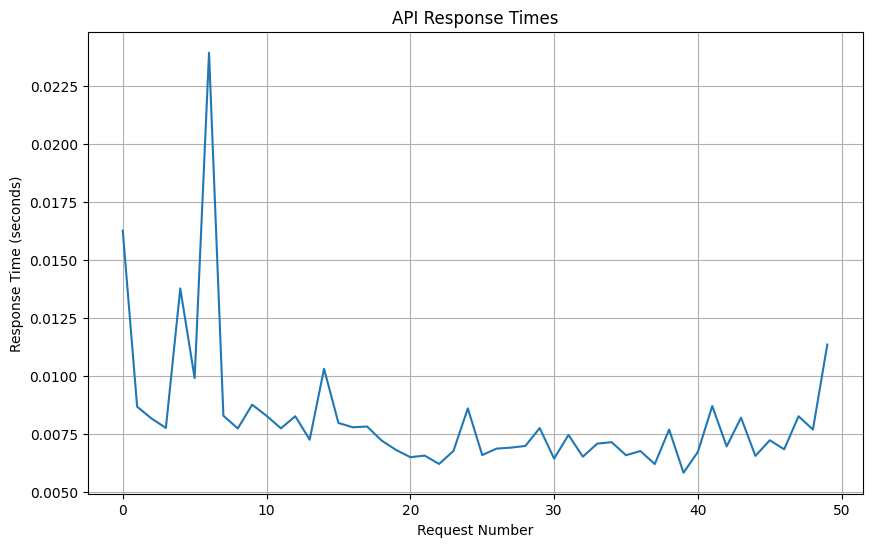

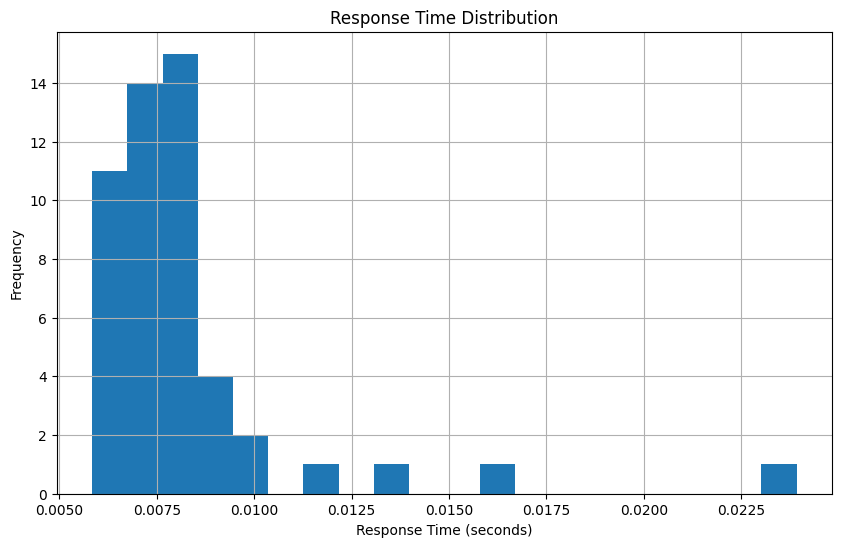

In [41]:
import matplotlib.pyplot as plt
import pandas as pd


def performance_test(url, headers=None, num_requests=50):
    """Test the performance of an endpoint by making multiple requests"""
    response_times = []
    success_count = 0
    
    for i in range(num_requests):
        start_time = time.time()
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                success_count += 1
        except:
            pass
        elapsed = time.time() - start_time
        response_times.append(elapsed)
    
    return {
        "response_times": response_times,
        "success_rate": (success_count / num_requests) * 100
    }

# Test performance for protected endpoint
num_requests = 50
print(f"Running performance test with {num_requests} requests...")
perf_results = performance_test(PROTECTED_ENDPOINT, headers=AUTH_HEADERS, num_requests=num_requests)

# Calculate statistics
avg_time = sum(perf_results["response_times"]) / len(perf_results["response_times"])
max_time = max(perf_results["response_times"])
min_time = min(perf_results["response_times"])

print(f"Average response time: {avg_time:.4f} seconds")
print(f"Maximum response time: {max_time:.4f} seconds")
print(f"Minimum response time: {min_time:.4f} seconds")
print(f"Success rate: {perf_results['success_rate']:.2f}%")

# Plot the response times
plt.figure(figsize=(10, 6))
plt.plot(perf_results["response_times"])
plt.title("API Response Times")
plt.xlabel("Request Number")
plt.ylabel("Response Time (seconds)")
plt.grid(True)
plt.show()

# Plot the histogram of response times
plt.figure(figsize=(10, 6))
plt.hist(perf_results["response_times"], bins=20)
plt.title("Response Time Distribution")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 7. Automated Testing with unittest

Let's create some automated tests using the unittest framework.

In [42]:
class FastAPITests(unittest.TestCase):
    def setUp(self):
        self.base_url = BASE_URL
        self.api_key = API_KEY
        self.auth_headers = {"X-API-Key": self.api_key}
    
    def test_public_endpoint(self):
        """Test the public endpoint"""
        response = requests.get(f"{self.base_url}/")
        self.assertEqual(response.status_code, 200)
        self.assertIn("message", response.json())
    
    def test_protected_endpoint_no_auth(self):
        """Test that the protected endpoint fails without auth"""
        response = requests.get(f"{self.base_url}/hello")
        self.assertEqual(response.status_code, 401)
    
    def test_protected_endpoint_with_auth(self):
        """Test that the protected endpoint works with auth"""
        response = requests.get(f"{self.base_url}/hello", headers=self.auth_headers)
        self.assertEqual(response.status_code, 200)
        self.assertIn("message", response.json())
        self.assertEqual(response.json()["message"], "Hello, welcome to FastAPI!")
    
    def test_protected_endpoint_wrong_key(self):
        """Test that the protected endpoint fails with wrong auth"""
        wrong_headers = {"X-API-Key": "wrong-key"}
        response = requests.get(f"{self.base_url}/hello", headers=wrong_headers)
        self.assertEqual(response.status_code, 401)

# Run the tests
suite = unittest.TestLoader().loadTestsFromTestCase(FastAPITests)
unittest.TextTestRunner(verbosity=2).run(suite)

test_protected_endpoint_no_auth (__main__.FastAPITests.test_protected_endpoint_no_auth)
Test that the protected endpoint fails without auth ... ok
test_protected_endpoint_with_auth (__main__.FastAPITests.test_protected_endpoint_with_auth)
Test that the protected endpoint works with auth ... ok
test_protected_endpoint_wrong_key (__main__.FastAPITests.test_protected_endpoint_wrong_key)
Test that the protected endpoint fails with wrong auth ... ok
test_public_endpoint (__main__.FastAPITests.test_public_endpoint)
Test the public endpoint ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.043s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

## 8. Summary and Report

Let's generate a final report about our API testing.

In [43]:
def generate_report():
    """Generate a report of API testing results"""
    
    # Test different endpoints
    endpoints = [
        {"name": "Public Endpoint", "url": PUBLIC_ENDPOINT, "headers": None, "expected": 200},
        {"name": "Protected Endpoint (No Auth)", "url": PROTECTED_ENDPOINT, "headers": None, "expected": 401},
        {"name": "Protected Endpoint (With Auth)", "url": PROTECTED_ENDPOINT, "headers": AUTH_HEADERS, "expected": 200},
        {"name": "Protected Endpoint (Wrong Auth)", "url": PROTECTED_ENDPOINT, "headers": {"X-API-Key": "wrong"}, "expected": 401}
    ]
    
    results = []
    for endpoint in endpoints:
        start_time = time.time()
        try:
            response = requests.get(endpoint["url"], headers=endpoint["headers"])
            success = response.status_code == endpoint["expected"]
            results.append({
                "name": endpoint["name"],
                "url": endpoint["url"],
                "status": response.status_code,
                "expected": endpoint["expected"],
                "success": success,
                "time": time.time() - start_time,
                "response": response.json() if response.status_code < 400 else response.text
            })
        except Exception as e:
            results.append({
                "name": endpoint["name"],
                "url": endpoint["url"],
                "status": "Error",
                "expected": endpoint["expected"],
                "success": False,
                "time": time.time() - start_time,
                "response": str(e)
            })
    
    # Create a DataFrame for the results
    df = pd.DataFrame(results)
    
    # Calculate success rate
    success_rate = (df["success"].sum() / len(df)) * 100
    
    # Display the report
    print(f"API Testing Report")
    print(f"=====================================")
    print(f"Base URL: {BASE_URL}")
    print(f"Tests run: {len(df)}")
    print(f"Success rate: {success_rate:.2f}%")
    print(f"Average response time: {df['time'].mean():.4f} seconds")
    print(f"=====================================")
    
    # Display the results table
    display(df[["name", "status", "expected", "success", "time"]])
    
    # Return success rate
    return success_rate

# Generate the report
success_rate = generate_report()

# Visual success indicator
if success_rate == 100:
    display(HTML('<div style="padding: 10px; background-color: #dff0d8; color: #3c763d; border: 1px solid #d6e9c6; border-radius: 4px;">All tests passed successfully! ✅</div>'))
else:
    display(HTML(f'<div style="padding: 10px; background-color: #f2dede; color: #a94442; border: 1px solid #ebccd1; border-radius: 4px;">Some tests failed. Success rate: {success_rate:.2f}% ❌</div>'))

API Testing Report
Base URL: http://localhost:8001
Tests run: 4
Success rate: 100.00%
Average response time: 0.0079 seconds


,name,status,expected,success,time
0,Public Endpoint,200,200,True,0.008115
1,Protected Endpoint (No Auth),401,401,True,0.007891
2,Protected Endpoint (With Auth),200,200,True,0.008248
3,Protected Endpoint (Wrong Auth),401,401,True,0.007341


## 9. Deploy to Azure Container Apps (Optional)

If you want to test against your Azure Container App deployment, update the `BASE_URL` variable with your Azure Container App URL and run the tests again.

```python
# Azure Container App URL
BASE_URL = "https://web-aca-app.[generated-text].[location-info].azurecontainerapps.io"

# Set the API key to match what you configured in Azure
API_KEY = "your-secure-api-key-value"
```

Make sure to set the API key in your Azure Container App with:

```bash
az containerapp update --name web-aca-app --resource-group web-fastapi-aca-rg --set-env-vars "API_KEY=your-secure-api-key-value"
```